# Sementic segmentation of flair1 data with a basic UNet

In [2]:
# import all the necessary modules
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from utils import *
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
import torch.nn.functional as F

/home/bertille/miniconda3/envs/env_pytorch/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dict_classes = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'swimming_pool',
14  : 'snow',
15  : 'clear cut',
16  : 'mixed',
17  : 'ligneous',
18  : 'greenhouse',
19  : 'other'}

colors = {
1   : '#db0e9a',
2   : '#938e7b',
3   : '#f80c00',
4   : '#a97101',
5   : '#1553ae',
6   : '#194a26',
7   : '#46e483',
8   : '#f3a60d',
9   : '#660082',
10  : '#55ff00',
11  : '#fff30d',
12  : '#e4df7c',
13  : '#3de6eb',
14  : '#ffffff',
15  : '#8ab3a0',
16  : '#6b714f',
17  : '#c5dc42',
18  : '#9999ff',
19  : '#000000'}

## Prepare the data
1) Download the data and split it into training, validation and test sets. 
2) Analyse the balance of classes in the dataset. 
3) Create a Dataloader
4) Load the data

In [27]:
class Flair1Dataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, split="all", seed = 42):
        super(Flair1Dataset, self).__init__()
        self.resize_transform = transforms.Resize((256, 256))
        self.resize_transform_l = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
        self.folder_path = folder_path
        self.split = split
        self.img_files = sorted(list(get_data_paths(Path(self.folder_path), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.mask_files = sorted(list(get_data_paths(Path(self.folder_path), 'MSK*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.total = len(self.img_files)
        random.seed(seed)  # For reproducibility
        shuffled_indices = list(range(self.total))
        random.shuffle(shuffled_indices)
        train_size = int(0.6 * self.total)  # 60% for training
        test_valid_size = self.total - train_size  # 40% for testing and validation
        valid_size = int(0.5 * test_valid_size)  # Half of the remaining 40% for validation
        if split =='all':
            self.indices = shuffled_indices
        elif split == "train":
            self.indices = shuffled_indices[:train_size]
        elif split == "valid":
            self.indices = shuffled_indices[train_size:train_size+valid_size]
        elif split == "test":
            self.indices = shuffled_indices[train_size+valid_size:]
        elif split == "toy_tr":
            self.indices = shuffled_indices[:40]
        elif split == "toy_vl":
            self.indices = shuffled_indices[40:60]
        else:
            raise ValueError("Invalid split. Choose 'all' 'train', 'valid' or 'test'.")
        self.img_files = [self.img_files[i] for i in self.indices]
        self.mask_files = [self.mask_files[i] for i in self.indices]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        data = rasterio.open(img_path).read()
        data = data[0:3, :, :]
        label = rasterio.open(mask_path).read()
        # Convert data to PIL Image for resizing
        data = np.transpose(data, (1, 2, 0))
        data = transforms.ToPILImage()(data)
        data = self.resize_transform(data)
        # Convert back to tensor
        data = transforms.ToTensor()(data)

        # Convert label to PIL Image for resizing
        label = np.transpose(label, (1, 2, 0))
        label = transforms.ToPILImage()(label)
        label = self.resize_transform_l(label)
        #print values uniques in label
        # Convert back to tensor
        label = torch.from_numpy(np.array(label, dtype=np.uint8)).unsqueeze(0)
        #Turn data and label into float between 0 and 1
        # data = data / 255
        # label = label / 255
        return data, label

In [5]:
folder_path = '../../data/flair1/'
batch_size = 2

torch.Size([256, 256, 3])


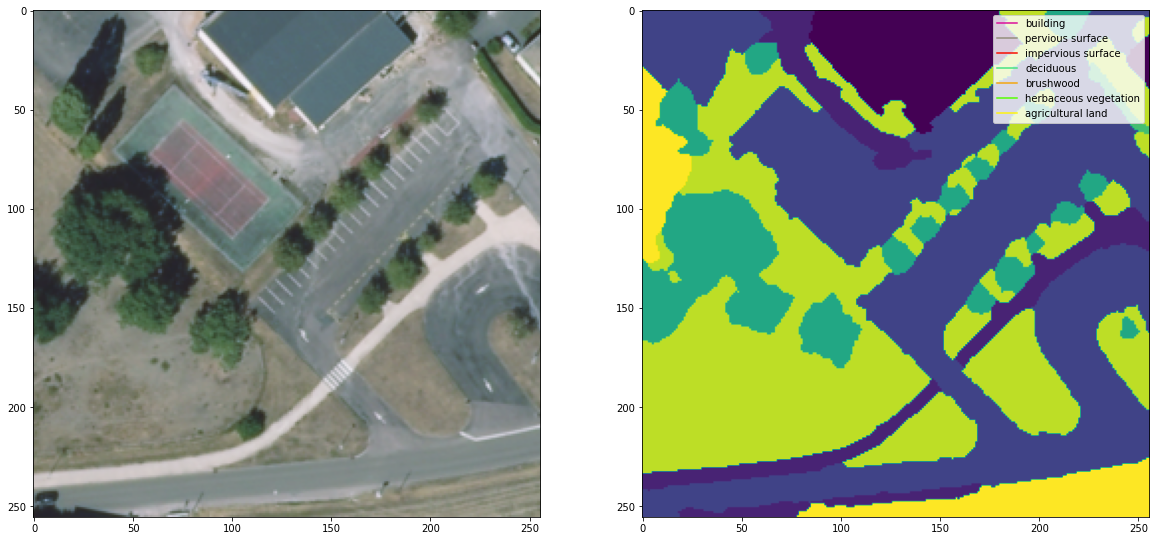

In [16]:
toy_ds = Flair1Dataset(folder_path, split="toy")
toy_dl = torch.utils.data.DataLoader(toy_ds, batch_size=batch_size, shuffle=True)
img, msk = next(iter(toy_dl))
plot_image_mask_2(img[0], msk[0], colors, dict_classes)

In [7]:
train_ds = Flair1Dataset(folder_path, split="train")
val_ds = Flair1Dataset(folder_path, split="valid")
test_ds = Flair1Dataset(folder_path, split="test")

In [8]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

## Create the model

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Adjust padding if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class SimpleUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SimpleUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.up1 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x = self.up1(x2, x1)
        logits = self.outc(x)
        return logits

## Create the functions for training, validation and test, with plots of the loss

In [25]:
from tqdm import tqdm

# Example train function with pixel-wise accuracy integration
def train(model, train_dl, val_dl, loss_fn, optimizer, epochs=1, device="cpu"):
    train_loss, val_loss = [], []
    train_pixel_acc, val_pixel_acc = [], []

    # Initialize pixel-wise accuracy objects
    num_classes = 20
    train_metrics = PixelwiseMetrics(num_classes)
    val_metrics = PixelwiseMetrics(num_classes)

    for epoch in range(epochs):
        model.train()
        batch_loss = []
        for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            xb = xb.float()
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            y_pred = model(xb)
            yb = yb.squeeze(1)
            yb = yb.long()
            loss = loss_fn(y_pred, yb)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            # Update training pixel-wise accuracy
            train_metrics.add_batch(yb, y_pred.argmax(dim=1))

        train_loss.append(np.mean(batch_loss))
        train_pixel_acc.append(train_metrics.get_average_accuracy())
        print(train_metrics.get_average_accuracy())

        model.eval()
        with torch.no_grad():
            batch_loss = []
            for xb, yb in tqdm(val_dl, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                xb, yb = xb.to(device), yb.to(device)
                y_pred = model(xb)
                yb = yb.squeeze(1)
                yb = yb.long()
                loss = loss_fn(y_pred, yb)
                batch_loss.append(loss.item())
                # Update validation pixel-wise accuracy
                val_metrics.add_batch(yb, y_pred.argmax(dim=1))

            val_loss.append(np.mean(batch_loss))
            val_pixel_acc.append(val_metrics.get_average_accuracy())

        print(
            f"Epoch {epoch}, train loss: {train_loss[-1]:.2f}, val loss: {val_loss[-1]:.2f}, "
            f"train pixel acc: {train_pixel_acc[-1]:.2f}, val pixel acc: {val_pixel_acc[-1]:.2f}"
        )

    return train_loss, val_loss, train_pixel_acc, val_pixel_acc

class PixelwiseMetrics(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.count = 0

        self.data = {"pixelclass_" + str(i): {"acc": 0} for i in range(num_classes)}

    def add_batch(self, y, y_hat):
        self.count += 1

        for c in range(self.num_classes):
            class_data = self.data["pixelclass_" + str(c)]
            preds_c = y_hat == c
            targs_c = y == c
            num_correct = (preds_c * targs_c).sum().cpu().detach().numpy()
            num_pixels = np.sum(targs_c.cpu().detach().numpy())
            class_data["acc"] += num_correct / num_pixels

    def get_classwise_accuracy(self):
        return {k: el['acc'] / self.count for k, el in self.data.items()}

    def get_average_accuracy(self):
        cw_acc = self.get_classwise_accuracy()
        return np.mean(list(cw_acc.values()))

## Run the algorithm for a tiny subset

In [29]:
toy_tr_ds = Flair1Dataset(folder_path, split="toy_tr")
toy_tr_dl = torch.utils.data.DataLoader(toy_tr_ds, batch_size=batch_size, shuffle=True)
toy_vl_ds = Flair1Dataset(folder_path, split="toy_vl")
toy_vl_dl = torch.utils.data.DataLoader(toy_vl_ds, batch_size=batch_size, shuffle=True)
model = UNet(3, 20) #pixel value from 1 to 18
#model = SimpleUNet(3, 18)
model = model.float()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss, val_loss, train_pixel_acc, val_pixel_acc = train(model, toy_tr_ds, toy_vl_ds, loss_fn, optimizer, epochs=5)

Epoch 1/5 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 256, 256] instead